# **Подготовка**

In [ ]:
!pip install optuna

import tensorflow as tf
from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import time
import datetime
from pandas.tseries.offsets import DateOffset
from sklearn.model_selection import GridSearchCV
import requests
import pandas as pd
import xml.etree.ElementTree as ET
import pandas as pd
from datetime import datetime
import optuna
import optuna.visualization as visualization
from optuna.trial import Trial
#import xgboost as xgb
import holidays
#from sktime.utils.plotting import plot_series

In [ ]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:

# Загрузка датасета с курсом
exchange_rates = pd.read_csv('/content/gdrive/MyDrive/usdrub_d.csv', parse_dates=['Date'])
exchange_rates.rename(columns={'Date': 'ds'}, inplace=True)

# Загрузка вашего датасета
your_data = pd.read_csv('/content/gdrive/MyDrive/DataStore/salesD_smoothed.csv', parse_dates=['ds'])
#your_data = pd.read_csv('/content/gdrive/MyDrive/DataStore/salesD_double_smoothed.csv', parse_dates=['ds'])

# Объединение датасетов
merged_df = pd.merge(your_data, exchange_rates, on='ds', how='left')

# Заполнение пропусков
merged_df['Close'] = merged_df['Close'].fillna(method='ffill')

# Сохранение объединенного датасета
merged_df.to_csv('merged_data.csv', index=False)


<ipython-input-78-e1d02170ade3>:13: FutureWarning:

Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.



In [ ]:

data = pd.read_csv('merged_data.csv', parse_dates=['ds'])

ru_holidays = holidays.RU()

# Добавление столбца с индикатором праздников
data['is_holiday'] = 0
for i in range(len(data)):
    date = data['ds'][i]
    if date in ru_holidays:
        data.loc[i, 'is_holiday'] = 1  # Используем .loc

# Сохранение обновленного датасета
data.to_csv('your_data_with_holidays.csv', index=False)


In [ ]:
'''
# Загрузка датасета с курсом
Deficis = pd.read_csv('/content/gdrive/MyDrive/DataStore/дефицит_ОИ.csv', parse_dates=['Date'])
Deficis.rename(columns={'Date': 'ds'}, inplace=True)

# Загрузка вашего датасета
your_data = pd.read_csv('your_data_with_holidays.csv', parse_dates=['ds'])

# Объединение датасетов
merged_df = pd.merge(your_data, Deficis, on='ds', how='left')

# Заполнение пропусков
merged_df['Def'] = merged_df['%_Номенкл_вДеф'].fillna(method='ffill')

# Сохранение объединенного датасета
merged_df.to_csv('completed_data.csv', index=False)
'''

"\n# Загрузка датасета с курсом\nDeficis = pd.read_csv('/content/gdrive/MyDrive/DataStore/дефицит_ОИ.csv', parse_dates=['Date'])\nDeficis.rename(columns={'Date': 'ds'}, inplace=True)\n\n# Загрузка вашего датасета\nyour_data = pd.read_csv('your_data_with_holidays.csv', parse_dates=['ds'])\n\n# Объединение датасетов\nmerged_df = pd.merge(your_data, Deficis, on='ds', how='left')\n\n# Заполнение пропусков\nmerged_df['Def'] = merged_df['%_Номенкл_вДеф'].fillna(method='ffill')\n\n# Сохранение объединенного датасета\nmerged_df.to_csv('completed_data.csv', index=False)\n"

In [ ]:

df_forFCST = pd.read_csv(  r'your_data_with_holidays.csv' )

df_forFCST.set_index( 'ds', inplace = True )
df_forFCST.index = pd.to_datetime( df_forFCST.index )
df_forFCST.index
#df_forFCST['Def'] = df_forFCST['Def'].str.replace(',', '.')


DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2024-07-22', '2024-07-23', '2024-07-24', '2024-07-25',
               '2024-07-26', '2024-07-27', '2024-07-28', '2024-07-29',
               '2024-07-30', '2024-07-31'],
              dtype='datetime64[ns]', name='ds', length=2039, freq=None)

In [ ]:
def windowed_dataset( series, window_size, batch_size ):
    """Generates dataset windows

    Args:
      series (array of float) - contains the values of the time series
      window_size (int) - the number of time steps to include in the feature
      batch_size (int) - the batch size
      shuffle_buffer(int) - buffer size to use for the shuffle method

    Returns:
      dataset (TF Dataset) - TF Dataset containing time windows
    """

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))

    # Create tuples with features and labels
    dataset = dataset.map(lambda window: (window[:-1], window[-1, 0])) # Extract 'y_mix' as the label

    # Create batches of windows
    # dataset = dataset.batch( batch_size ).prefetch(1)
    dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

    return dataset

# Visualizes time series data
def plot_series(x, y, format="-", start=0, end=None,
                title=None, xlabel=None, ylabel=None, legend=None ):
    """
    Visualizes time series data

    Args:
      x (array of int) - contains values for the x-axis
      y (array of int or tuple of arrays) - contains the values for the y-axis
      format (string) - line style when plotting the graph
      label (string) - tag for the line
      start (int) - first time step to plot
      end (int) - last time step to plot
      title (string) - title of the plot
      xlabel (string) - label for the x-axis
      ylabel (string) - label for the y-axis
      legend (list of strings) - legend for the plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(8, 4))

    # Check if there are more than two series to plot
    if type(y) is tuple:

      # Loop over the y elements
      for y_curr in y:

        # Plot the x and current y values
        plt.plot(x[start:end], y_curr[start:end], format)

    else:
      # Plot the x and y values
      plt.plot(x[start:end], y[start:end], format)

    # Label the x-axis
    plt.xlabel(xlabel)

    # Label the y-axis
    plt.ylabel(ylabel)

    # Set the legend
    if legend:
      plt.legend(legend)

    # Set the title
    plt.title(title)

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

# Feature engineering after split
def add_features( df, max_mix ):
  df = df.copy()
  # max_mix = df.y_mix.max()
  df['y_mix'] = df.y_mix / max_mix
  df['month_number'] = df.index.month / df.index.month.max()
  df['day_of_week'] = df.index.dayofweek / df.index.dayofweek.max()
  df['day_of_month'] = df.index.day / df.index.day.max()
  df['Close'] = df['Close'] / df['Close'].max()
  #df['Def'] = df['Def'].str.rstrip('%').astype('float') / 100  # Remove '%' and convert to float

  return df

# **Поиск**

In [ ]:
# Split data first
split_dateSm = pd.to_datetime( '2024-04-30' )
train_dfSm = df_forFCST[ df_forFCST.index <= split_dateSm ]
#valid_dfSm = df_forFCST[ df_forFCST.index > split_dateSm ]


max_mix = df_forFCST[ df_forFCST.index <= split_dateSm ]['y_mix'].max()
train_dfSm = add_features( train_dfSm, max_mix )
#valid_dfSm = add_features( valid_dfSm, max_mix )

# Form numpy arrays
time_trainSm = np.array( train_dfSm.reset_index()['ds'] )
x_trainSm = np.array( train_dfSm[['y_mix', 'month_number', 'day_of_week', 'day_of_month', 'is_holiday', 'Close']] )

#time_validSm = np.array( valid_dfSm.reset_index()['ds'])
#x_validSm = np.array( valid_dfSm[['y_mix', 'month_number', 'day_of_week', 'day_of_month']] )
print(len(x_trainSm))

1947


In [ ]:
features = ['month_number', 'day_of_week', 'day_of_month', 'Close', 'is_holiday']
target = 'y_mix'

# Prepare data for XGBoost
dateSm = add_features( df_forFCST, max_mix )

X = dateSm[features]
y = dateSm[target]

split_dateSm = pd.to_datetime( '2024-02-29' )
ltrain_dfSm = df_forFCST[ df_forFCST.index <= split_dateSm ]

date_max_mix = len(ltrain_dfSm)

# Split data into training and testing sets (adjust test_size as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1 - (date_max_mix / len(df_forFCST)), shuffle=False)
X_test = X_test[:-61]
y_test = y_test[:-61]
print(X_test)

            month_number  day_of_week  day_of_month     Close  is_holiday
ds                                                                       
2024-03-01      0.250000     0.666667      0.032258  0.603407           0
2024-03-02      0.250000     0.833333      0.064516  0.603407           0
2024-03-03      0.250000     1.000000      0.096774  0.603407           0
2024-03-04      0.250000     0.000000      0.129032  0.601179           0
2024-03-05      0.250000     0.166667      0.161290  0.597251           0
...                  ...          ...           ...       ...         ...
2024-05-27      0.416667     0.000000      0.870968  0.583352           0
2024-05-28      0.416667     0.166667      0.903226  0.581544           0
2024-05-29      0.416667     0.333333      0.935484  0.588775           0
2024-05-30      0.416667     0.500000      0.967742  0.591733           0
2024-05-31      0.416667     0.666667      1.000000  0.594033           0

[92 rows x 5 columns]


In [ ]:
model = XGBRegressor(objective='reg:squarederror',
                    n_estimators=558,  # Adjust as needed
                    max_depth=11,  # Adjust as needed
                    learning_rate=0.4,  # Adjust as needed
                    subsample=0.8866,  # Adjust as needed
                    #colsample_bytree=1,  # Adjust as needed
                    #reg_alpha=0,  # Adjust as needed
                    reg_lambda=0.392)  # Adjust as needed

# Train the model
model.fit(X_train, y_train)

# Make predictions on test data
y_pred = model.predict(X_test)

# Evaluate model performance
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")


RMSE: 0.0835
MAE: 0.0612


In [ ]:
def objective(trial):
    """Целевая функция для Optuna."""
    '''
    llrat = [0.287, 0.319, 0.301, 0.339, 0.340, 0.337]
    rlrat = [0.327, 0.359, 0.341, 0.379, 0.380, 0.377]
    ldep = [9, 9, 9, 9, 9, 10]
    rdep = [11, 11, 11, 11, 12, 12]
    lest = [616, 1816, 1855, 1929, 1919, 2261]
    rest = [660, 1856, 1895, 1949, 1959, 2301]
    llamb = [0.393, 0.349, 0.371, 0.384, 0.38, 0.370]
    rlamb = [0.433, 0.389, 0.411, 0.424, 0.427, 0.410]
    lsub = [0.88, 0.884, 0.884, 0.884, 0.884, 0.884]
    rsub = [0.89, 0.886, 0.886, 0.886, 0.886, 0.886]
    '''
    llrat = [0.25, 0.43, 0.3, 0.25, 0.25, 0.26]
    rlrat = [0.3, 0.53, 0.35, 0.3, 0.3, 0.32]
    ldep = [7, 8, 9, 7, 9, 9]
    rdep = [9, 10, 11, 10, 11, 11]
    lest = [450, 100, 240, 380, 480, 630]
    rest = [530, 170, 310, 470, 570, 700]
    llamb = [0.35, 0.26, 0.32, 0.17, 0.2, 0.2]
    rlamb = [0.4, 0.33, 0.4, 0.23, 0.28, 0.28]
    lsub = [0.88, 0.88, 0.88, 0.88, 0.88, 0.88]
    rsub = [0.886, 0.886, 0.886, 0.886, 0.886, 0.886]
    # Определение параметров модели (с помощью Optuna)
    params = {
        'learning_rate': trial.suggest_float('learning_rate', llrat[3], rlrat[3]),
        'max_depth': trial.suggest_int('max_depth', ldep[3], rdep[3]),
        'n_estimators': trial.suggest_int('n_estimators', lest[3], rest[3]),
        'reg_lambda': trial.suggest_float('reg_lambda', llamb[3], rlamb[3]),
        'subsample': trial.suggest_float('subsample', lsub[3], rsub[3]),
        #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.85, 0.95),
        #'gamma': trial.suggest_float('gamma', 0.01, 0.08),
        #'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 0.06)
    }

    # Создание и обучение модели
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)

    # Предсказание на тестовой выборке
    y_pred = model.predict(X_test)

    # Вычисление метрики (например, MSE)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return mse

In [ ]:
# Создание исследования
study = optuna.create_study(direction='minimize')  # Минимизация MSE

# Запуск исследования (количество проб)
study.optimize(objective, n_trials=50)

# Получение лучших параметров
best_params = study.best_params



[I 2024-08-30 19:35:52,131] A new study created in memory with name: no-name-6f363b18-16c7-427e-8be2-614e10faa35f
[I 2024-08-30 19:35:53,954] Trial 0 finished with value: 0.010924747782061605 and parameters: {'learning_rate': 0.2654087178282604, 'max_depth': 7, 'n_estimators': 443, 'reg_lambda': 0.18710387526796318, 'subsample': 0.8806009472987973}. Best is trial 0 with value: 0.010924747782061605.
[I 2024-08-30 19:35:59,591] Trial 1 finished with value: 0.0093739429446437 and parameters: {'learning_rate': 0.26705664894178005, 'max_depth': 8, 'n_estimators': 435, 'reg_lambda': 0.22060905704997585, 'subsample': 0.8808211535869432}. Best is trial 1 with value: 0.0093739429446437.
[I 2024-08-30 19:36:07,731] Trial 2 finished with value: 0.008461552093226068 and parameters: {'learning_rate': 0.2530845415706453, 'max_depth': 10, 'n_estimators': 386, 'reg_lambda': 0.18478229504362445, 'subsample': 0.8809179675561608}. Best is trial 2 with value: 0.008461552093226068.
[I 2024-08-30 19:36:21,9

In [ ]:
fig = optuna.visualization.plot_slice(study)
fig.show()
fig = optuna.visualization.plot_contour(study, params=["learning_rate", "n_estimators"])
fig.show()

In [ ]:
best_model = XGBRegressor(**best_params)
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

# Вывод результатов
print("Лучшие параметры:", best_params)
print("Лучшее MSE:", study.best_value)

#Лучшие параметры: {'learning_rate': 0.3182949958253294, 'max_depth': 10, 'n_estimators': 407, 'reg_lambda': 0.2742862547914231, 'subsample': 0.8825848522066012}
#Лучшее MSE: 0.006891363690823102 in 6 10 6 * 9 14
#Лучшие параметры: {'learning_rate': 0.3994365597578713, 'max_depth': 11, 'n_estimators': 558, 'reg_lambda': 0.39225250388649985, 'subsample': 0.8866179858479619}
#Лучшее MSE: 0.006627326096072932 in 1 6 8 *** 11 13
#Лучшие параметры: {'learning_rate': 0.3355703458527617, 'max_depth': 9, 'n_estimators': 636, 'reg_lambda': 0.4490532882539572, 'subsample': 0.9621801025217974}
#Лучшее MSE: 0.00786367578690096 in 3 9 9 * 13 13
#Лучшие параметры: {'learning_rate': 0.30783611682175427, 'max_depth': 10, 'n_estimators': 636, 'reg_lambda': 0.4134393145737115, 'subsample': 0.8847262850015434}
#Лучшее MSE: 0.007121910764723661 in 3 8 10 * 9 12 +


#Лучшие параметры: {'learning_rate': 0.3397765711907539, 'max_depth': 10, 'n_estimators': 1836, 'reg_lambda': 0.3691992127987541, 'subsample': 0.8844566726152161}
#Лучшее MSE: 0.00733613539109482 in 5 8 9 * 9 12 +
#Лучшие параметры: {'learning_rate': 0.3284016550206801, 'max_depth': 10, 'n_estimators': 2195, 'reg_lambda': 0.3727446185612196, 'subsample': 0.8846373746982938}
#Лучшее MSE: 0.007152110410405082 in 3 9 9 ** 9 13
#Лучшие параметры: {'learning_rate': 0.3211186799575672, 'max_depth': 10, 'n_estimators': 1877, 'reg_lambda': 0.39135729674424685, 'subsample': 0.8857549212608521}
#Лучшее MSE: 0.006967277988112154 in 2 7 8 * 8 11 + if 66
#Лучшие параметры: {'learning_rate': 0.35924471245534034, 'max_depth': 10, 'n_estimators': 1949, 'reg_lambda': 0.4045864516634997, 'subsample': 0.8847827831580451}
#Лучшее MSE: 0.006775318865764842 in 2 5 7 *** 7 12 +
#Лучшие параметры: {'learning_rate': 0.3601054180113842, 'max_depth': 10, 'n_estimators': 1939, 'reg_lambda': 0.4069343730824307, 'subsample': 0.8846860977112866}
#Лучшее MSE: 0.006737210201676588 in 2 6 8 ** 8 11 +
#Лучшие параметры: {'learning_rate': 0.357337404773028, 'max_depth': 11, 'n_estimators': 2281, 'reg_lambda': 0.3900003547708684, 'subsample': 0.8858256502901554}
#Лучшее MSE: 0.0068440557464229295 in 3 5 6 ** 7 12 +

'''
llrat = [0.298, 0.358, 0.379, 0.315, 0.287, 0.319, 0.308, 0.301, 0.339, 0.340, 0.337]
rlrat = [0.338, 0.398, 0.419, 0.355, 0.327, 0.359, 0.348, 0.341, 0.379, 0.380, 0.377]
ldep = [9, 10, 10, 8, 9, 9, 9, 9, 9, 9, 10]
rdep = [11, 12, 12, 10, 11, 11, 11, 11, 11, 11, 12]
lest = [377, 480, 538, 616, 616, 1816, 2175, 1855, 1929, 1919, 2261]
rest = [417, 520, 578, 656, 660, 1856, 2215, 1895, 1949, 1959, 2301]
llamb = [0.254, 0.206, 0.372, 0.429, 0.393, 0.349, 0.352, 0.371, 0.384, 0.387, 0.370]
rlamb = [0.294, 0.246, 0.412, 0.469, 0.433, 0.389, 0.392, 0.411, 0.424, 0.427, 0.410]
lsub = [0.88, 0.88, 0.88, 0.88, 0.88, 0.884, 0.884, 0.884, 0.884, 0.884, 0.884]
rsub = [0.89, 0.89, 0.89, 0.97, 0.89, 0.886, 0.886, 0.886, 0.886, 0.886, 0.886]
'''

#Лучшие параметры: {'learning_rate': 0.27445445590811335, 'max_depth': 8, 'n_estimators': 496, 'reg_lambda': 0.3730614994956989, 'subsample': 0.8816430889479492}
#Лучшее MSE: 0.006902758573655119 in 8 10 **
#Лучшие параметры: {'learning_rate': 0.4958928932294147, 'max_depth': 9, 'n_estimators': 116, 'reg_lambda': 0.32633912343268673, 'subsample': 0.8855036865063138}
#Лучшее MSE: 0.007925420176050023 in 9 10 *
#Лучшие параметры: {'learning_rate': 0.3296230266116008, 'max_depth': 10, 'n_estimators': 287, 'reg_lambda': 0.3775694728781185, 'subsample': 0.8848977322876512}
#Лучшее MSE: 0.0069163666010920374 in 9 13 *
#Лучшие параметры: {'learning_rate': 0.2789699764501914, 'max_depth': 10, 'n_estimators': 427, 'reg_lambda': 0.20673125613500598, 'subsample': 0.8829012963557951}
#Лучшее MSE: 0.006352706140367311 in 8 11 ** 25 33 8 11 370 500 0.15 0.25 88 886
#Лучшие параметры: {'learning_rate': 0.2856104924349824, 'max_depth': 10, 'n_estimators': 510, 'reg_lambda': 0.23793824031193395, 'subsample': 0.8833232256381509}
#Лучшее MSE: 0.006578314092417606 in 9 12 * 25 37 8 11 450 550 15 25 88 886
#Лучшие параметры: {'learning_rate': 0.28145983271951397, 'max_depth': 10, 'n_estimators': 652, 'reg_lambda': 0.22113306297386875, 'subsample': 0.8840681120077459}
#Лучшее MSE: 0.006465865244146952 in 9 11

Лучшие параметры: {'learning_rate': 0.2739710363443391, 'max_depth': 10, 'n_estimators': 419, 'reg_lambda': 0.18611292361758738, 'subsample': 0.8844881048850051}
Лучшее MSE: 0.007104434799024892


'\nllrat = [0.298, 0.358, 0.379, 0.315, 0.287, 0.319, 0.308, 0.301, 0.339, 0.340, 0.337]\nrlrat = [0.338, 0.398, 0.419, 0.355, 0.327, 0.359, 0.348, 0.341, 0.379, 0.380, 0.377]\nldep = [9, 10, 10, 8, 9, 9, 9, 9, 9, 9, 10]\nrdep = [11, 12, 12, 10, 11, 11, 11, 11, 11, 11, 12]\nlest = [377, 480, 538, 616, 616, 1816, 2175, 1855, 1929, 1919, 2261]\nrest = [417, 520, 578, 656, 660, 1856, 2215, 1895, 1949, 1959, 2301]\nllamb = [0.254, 0.206, 0.372, 0.429, 0.393, 0.349, 0.352, 0.371, 0.384, 0.387, 0.370]\nrlamb = [0.294, 0.246, 0.412, 0.469, 0.433, 0.389, 0.392, 0.411, 0.424, 0.427, 0.410]\nlsub = [0.88, 0.88, 0.88, 0.88, 0.88, 0.884, 0.884, 0.884, 0.884, 0.884, 0.884]\nrsub = [0.89, 0.89, 0.89, 0.97, 0.89, 0.886, 0.886, 0.886, 0.886, 0.886, 0.886]\n'

In [ ]:
# TEST PREDICTION

# Split data first
split_dateSm = pd.to_datetime( '2024-02-29' )
upper_boundary = pd.to_datetime( '2024-05-31' )
train_dfSm = df_forFCST[ df_forFCST.index <= split_dateSm ]
valid_dfSm = df_forFCST[ ( df_forFCST.index > split_dateSm ) & ( df_forFCST.index <= upper_boundary ) ]

# max_mix = df_forFCST[ df_forFCST.index <= split_dateSm ]['y_mix'].max()
max_mix = 679.8297498652444
train_dfSm = add_features( train_dfSm, max_mix )
valid_dfSm = add_features( valid_dfSm, max_mix )

# Form numpy arrays
time_trainSm = np.array( train_dfSm.reset_index()['ds'] )
x_trainSm = np.array( train_dfSm[['y_mix', 'month_number', 'day_of_week', 'day_of_month', 'Close']] )

time_validSm = np.array( valid_dfSm.reset_index()['ds'])
x_validSm = np.array( valid_dfSm[['y_mix', 'month_number', 'day_of_week', 'day_of_month', 'Close']] )


results = y_pred
forecast_date = pd.to_datetime(time_validSm[0])
month_num = forecast_date.month / 12
day_of_week = forecast_date.dayofweek / 6
day_of_month = forecast_date.day / 31


data = np.array( [ y_test  * max_mix, results * max_mix ] ).T

df_result = pd.DataFrame( data = data, index = time_validSm,
                          columns = [ "x_valid", "prediction"] )
df_resultGR = df_result.groupby( pd.Grouper( freq = "M" ) ).sum()
p_error = np.abs( np.array( df_resultGR["x_valid"] ) - ( np.array( df_resultGR['prediction'] ) ) ) \
    / np.array( df_resultGR["x_valid"] )

df_resultGR = df_result.groupby( pd.Grouper( freq = "M" ) ).sum()
df_resultGR['a_error'] = np.abs( np.round( \
    np.array( df_resultGR["x_valid"] ) \
    - np.array( df_resultGR['prediction'] ), 0 ) )
df_resultGR['p_error'] = np.round( ( np.array( df_resultGR["x_valid"] ) \
    -  np.array( df_resultGR['prediction'] ) ) \
    / np.array( df_resultGR["x_valid"] ), 2 )

df_resultGR

,x_valid,prediction,a_error,p_error
2024-03-31,8098.406273,7835.221329,263.0,0.03
2024-04-30,8102.309590,7129.193398,973.0,0.12
2024-05-31,9059.598005,8141.241928,918.0,0.10


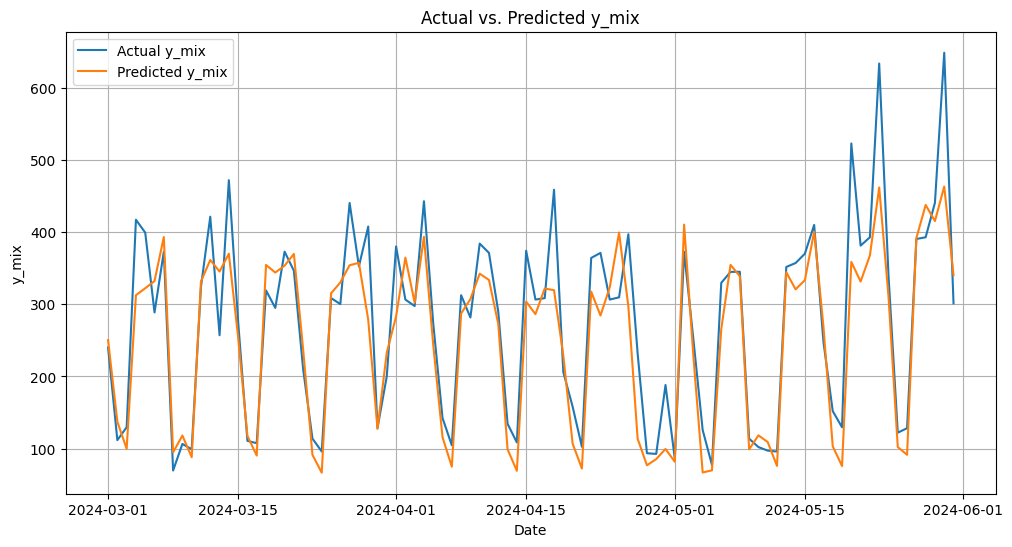

            month_number  day_of_week  day_of_month     Close  is_holiday
ds                                                                       
2024-03-01      0.250000     0.666667      0.032258  0.603407           0
2024-03-02      0.250000     0.833333      0.064516  0.603407           0
2024-03-03      0.250000     1.000000      0.096774  0.603407           0
2024-03-04      0.250000     0.000000      0.129032  0.601179           0
2024-03-05      0.250000     0.166667      0.161290  0.597251           0
...                  ...          ...           ...       ...         ...
2024-05-27      0.416667     0.000000      0.870968  0.583352           0
2024-05-28      0.416667     0.166667      0.903226  0.581544           0
2024-05-29      0.416667     0.333333      0.935484  0.588775           0
2024-05-30      0.416667     0.500000      0.967742  0.591733           0
2024-05-31      0.416667     0.666667      1.000000  0.594033           0

[92 rows x 5 columns]
ds
2024-03-01  

In [ ]:
plt.figure(figsize=(12, 6))

# Plot actual sales values
plt.plot(X_test.index, y_test * max_mix, label='Actual y_mix')

# Plot predicted sales values
plt.plot(X_test.index, y_pred * max_mix, label='Predicted y_mix')


plt.xlabel('Date')
plt.ylabel('y_mix')
plt.title('Actual vs. Predicted y_mix')
plt.legend()
plt.grid(True)
plt.show()
print(X_test)
print(y_test)

In [ ]:
# Split data first
split_dateSm1 = pd.to_datetime( '2024-04-30' )
train_dfSm1 = df_forFCST[ df_forFCST.index <= split_dateSm ]
#valid_dfSm = df_forFCST[ df_forFCST.index > split_dateSm ]


max_mix1 = df_forFCST[ df_forFCST.index <= split_dateSm1 ]['y_mix'].max()
train_dfSm1 = add_features( train_dfSm1, max_mix1 )
#valid_dfSm = add_features( valid_dfSm, max_mix )

# Form numpy arrays
time_trainSm1 = np.array( train_dfSm1.reset_index()['ds'] )
x_trainSm1 = np.array( train_dfSm1[['y_mix', 'month_number', 'day_of_week', 'day_of_month', 'is_holiday']] )

#time_validSm = np.array( valid_dfSm.reset_index()['ds'])
#x_validSm = np.array( valid_dfSm[['y_mix', 'month_number', 'day_of_week', 'day_of_month']] )
print(len(x_trainSm1))

features1 = ['month_number', 'day_of_week', 'day_of_month', 'Close', 'is_holiday']
target1 = 'y_mix'

# Prepare data for XGBoost
dateSm1 = add_features( df_forFCST, max_mix1 )

X = dateSm1[features]
y = dateSm1[target]

split_dateSm1 = pd.to_datetime( '2024-04-30' )
ltrain_dfSm1 = df_forFCST[ df_forFCST.index <= split_dateSm1 ]

date_max_mix1 = len(ltrain_dfSm1)

# Split data into training and testing sets (adjust test_size as needed)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size= 1 - (date_max_mix1 / len(df_forFCST)), shuffle=False)
print(X_test1)

1886
            month_number  day_of_week  day_of_month     Close  is_holiday
ds                                                                       
2024-05-01      0.416667     0.333333      0.032258  0.614409           1
2024-05-02      0.416667     0.500000      0.064516  0.607821           0
2024-05-03      0.416667     0.666667      0.096774  0.604550           0
2024-05-04      0.416667     0.833333      0.129032  0.604550           0
2024-05-05      0.416667     1.000000      0.161290  0.604550           0
...                  ...          ...           ...       ...         ...
2024-07-27      0.583333     0.833333      0.870968  0.565934           0
2024-07-28      0.583333     1.000000      0.903226  0.565934           0
2024-07-29      0.583333     0.000000      0.935484  0.569549           0
2024-07-30      0.583333     0.166667      0.967742  0.569220           0
2024-07-31      0.583333     0.333333      1.000000  0.564956           0

[92 rows x 5 columns]


In [ ]:
# TEST PREDICTION

y_pred1 = best_model.predict(X_test1)

# Split data first
split_dateSm1 = pd.to_datetime( '2024-04-30' )
upper_boundary1 = pd.to_datetime( '2024-07-31' )
train_dfSm1 = df_forFCST[ df_forFCST.index <= split_dateSm1 ]
valid_dfSm1 = df_forFCST[ ( df_forFCST.index > split_dateSm1 ) & ( df_forFCST.index <= upper_boundary1 ) ]

# max_mix = df_forFCST[ df_forFCST.index <= split_dateSm ]['y_mix'].max()
max_mix1 = 679.8297498652444
train_dfSm1 = add_features( train_dfSm1, max_mix1 )
valid_dfSm1 = add_features( valid_dfSm1, max_mix1 )

# Form numpy arrays
time_trainSm1 = np.array( train_dfSm1.reset_index()['ds'] )
x_trainSm1 = np.array( train_dfSm1[['y_mix', 'month_number', 'day_of_week', 'day_of_month', 'Close']] )

time_validSm1 = np.array( valid_dfSm1.reset_index()['ds'])
x_validSm1 = np.array( valid_dfSm1[['y_mix', 'month_number', 'day_of_week', 'day_of_month', 'Close']] )


results1 = y_pred1
forecast_date1 = pd.to_datetime(time_validSm1[0])
month_num1 = forecast_date1.month / 12
day_of_week1 = forecast_date1.dayofweek / 6
day_of_month1 = forecast_date1.day / 31


data = np.array( [ y_test1  * max_mix1, results1 * max_mix1 ] ).T

df_result = pd.DataFrame( data = data, index = time_validSm1,
                          columns = [ "x_valid", "prediction"] )
df_resultGR1 = df_result.groupby( pd.Grouper( freq = "M" ) ).sum()
p_error = np.abs( np.array( df_resultGR1["x_valid"] ) - ( np.array( df_resultGR1['prediction'] ) ) ) \
    / np.array( df_resultGR1["x_valid"] )

df_resultGR1 = df_result.groupby( pd.Grouper( freq = "M" ) ).sum()
df_resultGR1['a_error'] = np.abs( np.round( \
    np.array( df_resultGR1["x_valid"] ) \
    - np.array( df_resultGR1['prediction'] ), 0 ) )
df_resultGR1['p_error'] = np.round( ( np.array( df_resultGR1["x_valid"] ) \
    -  np.array( df_resultGR1['prediction'] ) ) \
    / np.array( df_resultGR1["x_valid"] ), 2 )

df_resultGR1

,x_valid,prediction,a_error,p_error
2024-05-31,9059.598005,8141.241928,918.0,0.10
2024-06-30,8816.616542,7757.226624,1059.0,0.12
2024-07-31,8930.788554,8600.621086,330.0,0.04


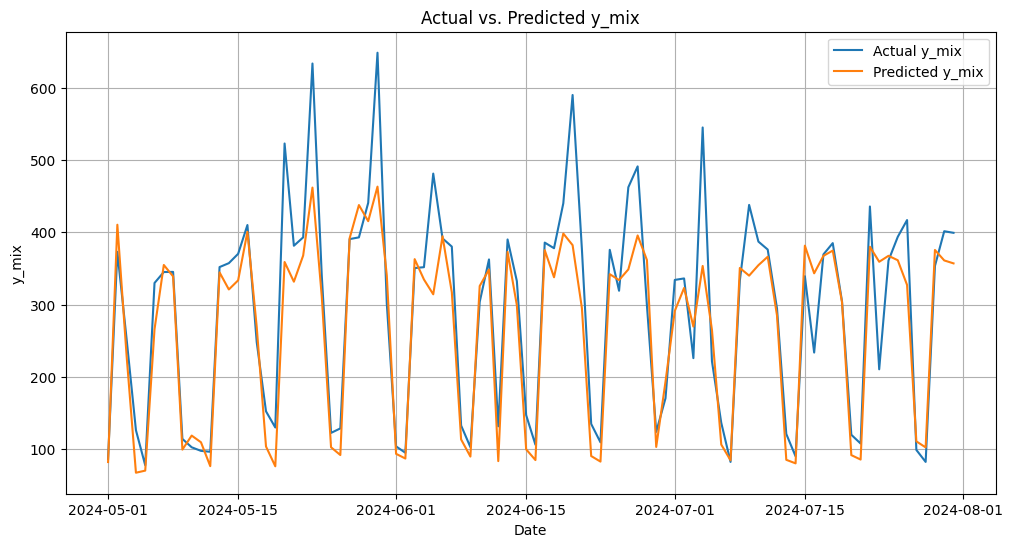

            month_number  day_of_week  day_of_month     Close  is_holiday
ds                                                                       
2024-03-01      0.250000     0.666667      0.032258  0.603407           0
2024-03-02      0.250000     0.833333      0.064516  0.603407           0
2024-03-03      0.250000     1.000000      0.096774  0.603407           0
2024-03-04      0.250000     0.000000      0.129032  0.601179           0
2024-03-05      0.250000     0.166667      0.161290  0.597251           0
...                  ...          ...           ...       ...         ...
2024-05-27      0.416667     0.000000      0.870968  0.583352           0
2024-05-28      0.416667     0.166667      0.903226  0.581544           0
2024-05-29      0.416667     0.333333      0.935484  0.588775           0
2024-05-30      0.416667     0.500000      0.967742  0.591733           0
2024-05-31      0.416667     0.666667      1.000000  0.594033           0

[92 rows x 5 columns]
ds
2024-03-01  

In [ ]:
plt.figure(figsize=(12, 6))

# Plot actual sales values
plt.plot(X_test1.index, y_test1 * max_mix, label='Actual y_mix')

# Plot predicted sales values
plt.plot(X_test1.index, y_pred1 * max_mix, label='Predicted y_mix')


plt.xlabel('Date')
plt.ylabel('y_mix')
plt.title('Actual vs. Predicted y_mix')
plt.legend()
plt.grid(True)
plt.show()
print(X_test)
print(y_test)

# **Финальная** **часть**


There are 6 models we take average of 2 median results for each month

In [ ]:

# Split data first
split_dateSm = pd.to_datetime( '2024-04-30' )
train_dfSm = df_forFCST[ df_forFCST.index <= split_dateSm ]
valid_dfSm = df_forFCST[ df_forFCST.index > split_dateSm ]


max_mix = df_forFCST[ df_forFCST.index <= split_dateSm ]['y_mix'].max()
train_dfSm = add_features( train_dfSm, max_mix )
valid_dfSm = add_features( valid_dfSm, max_mix )

# Form numpy arrays
time_trainSm = np.array( train_dfSm.reset_index()['ds'] )
x_trainSm = np.array( train_dfSm[['y_mix', 'month_number', 'day_of_week', 'day_of_month', 'is_holiday', 'Close']] )

time_validSm = np.array( valid_dfSm.reset_index()['ds'])
#x_validSm = np.array( valid_dfSm[['y_mix', 'month_number', 'day_of_week', 'day_of_month']] )
print(len(x_trainSm))


features = ['month_number', 'day_of_week', 'day_of_month', 'is_holiday', 'Close']
target = 'y_mix'

# Prepare data for XGBoost
dateSm = add_features( df_forFCST, max_mix )

X = dateSm[features]
y = dateSm[target]

split_dateSm = pd.to_datetime( '2024-04-30' )
ltrain_dfSm = df_forFCST[ df_forFCST.index <= split_dateSm ]

date_max_mix = len(ltrain_dfSm)

# Split data into training and testing sets (adjust test_size as needed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 1 - (date_max_mix / len(df_forFCST)), shuffle=False)
print(X_test)
print(X_train)

def objective(trial: Trial) -> float:
    """Целевая функция для Optuna."""
    '''

    llrat = [0.298, 0.358, 0.379, 0.315, 0.287, 0.319, 0.308, 0.301, 0.339, 0.340, 0.337]
    rlrat = [0.338, 0.398, 0.419, 0.355, 0.327, 0.359, 0.348, 0.341, 0.379, 0.380, 0.377]
    ldep = [9, 10, 10, 8, 9, 9, 9, 9, 9, 9, 10]
    rdep = [11, 12, 12, 10, 11, 11, 11, 11, 11, 11, 12]
    lest = [377, 480, 538, 616, 616, 1816, 2175, 1855, 1929, 1919, 2261]
    rest = [417, 520, 578, 656, 660, 1856, 2215, 1895, 1949, 1959, 2301]
    llamb = [0.254, 0.206, 0.372, 0.429, 0.393, 0.349, 0.352, 0.371, 0.384, 0.387, 0.370]
    rlamb = [0.294, 0.246, 0.412, 0.469, 0.433, 0.389, 0.392, 0.411, 0.424, 0.427, 0.410]
    lsub = [0.88, 0.88, 0.88, 0.88, 0.88, 0.884, 0.884, 0.884, 0.884, 0.884, 0.884]
    rsub = [0.89, 0.89, 0.89, 0.97, 0.89, 0.886, 0.886, 0.886, 0.886, 0.886, 0.886]
    '''
    llrat = [0.25, 0.43, 0.3, 0.28, 0.25, 0.26]
    rlrat = [0.3, 0.53, 0.35, 0.33, 0.3, 0.32]
    ldep = [7, 8, 9, 7, 9, 9]
    rdep = [9, 10, 11, 10, 11, 11]
    lest = [450, 100, 240, 420, 480, 630]
    rest = [530, 170, 310, 500, 570, 700]
    llamb = [0.35, 0.26, 0.32, 0.19, 0.2, 0.2]
    rlamb = [0.4, 0.33, 0.4, 0.23, 0.28, 0.28]
    lsub = [0.88, 0.88, 0.88, 0.88, 0.88, 0.88]
    rsub = [0.886, 0.886, 0.886, 0.886, 0.886, 0.886]

    # Определение параметров модели (с помощью Optuna)
    params = {
        'learning_rate': trial.suggest_float('learning_rate', llrat[i], rlrat[i]),
        'max_depth': trial.suggest_int('max_depth', ldep[i], rdep[i]),
        'n_estimators': trial.suggest_int('n_estimators', lest[i], rest[i]),
        'reg_lambda': trial.suggest_float('reg_lambda', llamb[i], rlamb[i]),
        'subsample': trial.suggest_float('subsample', lsub[i], rsub[i]),
        #'colsample_bytree': trial.suggest_float('colsample_bytree', 0.85, 0.95),
        #'gamma': trial.suggest_float('gamma', 0.01, 0.08),
        #'reg_alpha': trial.suggest_float('reg_alpha', 0.01, 0.06)
    }

    # Создание и обучение модели
    model = XGBRegressor(**params)
    model.fit(X_train, y_train)

    # Предсказание на тестовой выборке
    y_pred = model.predict(X_test)

    # Вычисление метрики (например, MSE)
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    return mse

for i in range(6):
    # Создание исследования
    study = optuna.create_study(direction='minimize')  # Минимизация MSE

    # Запуск исследования (количество проб)
    study.optimize(objective, n_trials=600)

    # Получение лучших параметров
    best_params = study.best_params

    # Обучение модели с лучшими параметрами
    best_model = XGBRegressor(**best_params)
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)

    # Вывод результатов
    print(f"Лучшие параметры для i={i}:", best_params)
    print(f"Лучшее MSE для i={i}:", study.best_value)


    results = y_pred
    forecast_date = pd.to_datetime(time_validSm[0])
    month_num = forecast_date.month / 12
    day_of_week = forecast_date.dayofweek / 6
    day_of_month = forecast_date.day / 31


    data = np.array( [ y_test  * max_mix, results * max_mix ] ).T

    df_result = pd.DataFrame( data = data, index = time_validSm,
                            columns = [ "x_valid", "prediction"] )
    df_resultGR = df_result.groupby( pd.Grouper( freq = "M" ) ).sum()
    p_error = np.abs( np.array( df_resultGR["x_valid"] ) - ( np.array( df_resultGR['prediction'] ) ) ) \
        / np.array( df_resultGR["x_valid"] )

    df_resultGR = df_result.groupby( pd.Grouper( freq = "M" ) ).sum()
    df_resultGR['a_error'] = np.abs( np.round( \
        np.array( df_resultGR["x_valid"] ) \
        - np.array( df_resultGR['prediction'] ), 0 ) )
    df_resultGR['p_error'] = np.round( ( np.array( df_resultGR["x_valid"] ) \
        -  np.array( df_resultGR['prediction'] ) ) \
        / np.array( df_resultGR["x_valid"] ), 2 )

    print(df_resultGR["x_valid"].values, df_resultGR['prediction'].values, df_resultGR["p_error"].values)
    print("------------------------")
    fig = optuna.visualization.plot_slice(study)
    fig.show()
#9 81- 10 76+             8 66-+ 10 77+-       13 72-- 67 10++          11 79+- 10 76-+     10 78-+ 11 72+-       11 77+ 11 70+-
#300trials:  75 5 11 7-22        73 10 7 6-23         71 8 8  2-18             77 11 10 0-21       73 8 11 2-21          72 9 11 2-22
#800trials:  73 7 7 1-15         66 6  9 5-20         68 12 9 4-25             77 7 10 0-17        73 10 8 0-18          69 10 11 2-23     8.5 9 1.5
#800trials:  74 11 12 1-24       80 9 10 3-22         68 8 11 2-21             76 9 10 3-22        74 12 11 2-25         75 8 10 3-21      9 10.5 2.5
#1500trials: 74 7 11 6-24        70 7 5 6-18          62 7 11 2-20             73 8 9 4-21         71 9 10 3-22          71 8 10 4-22      7.5 10 4

[I 2024-08-30 19:37:06,015] A new study created in memory with name: no-name-b1078ef2-33f2-4e48-a539-ae7157c68610


1947
            month_number  day_of_week  day_of_month  is_holiday     Close
ds                                                                       
2024-05-01      0.416667     0.333333      0.032258           1  0.614409
2024-05-02      0.416667     0.500000      0.064516           0  0.607821
2024-05-03      0.416667     0.666667      0.096774           0  0.604550
2024-05-04      0.416667     0.833333      0.129032           0  0.604550
2024-05-05      0.416667     1.000000      0.161290           0  0.604550
...                  ...          ...           ...         ...       ...
2024-07-27      0.583333     0.833333      0.870968           0  0.565934
2024-07-28      0.583333     1.000000      0.903226           0  0.565934
2024-07-29      0.583333     0.000000      0.935484           0  0.569549
2024-07-30      0.583333     0.166667      0.967742           0  0.569220
2024-07-31      0.583333     0.333333      1.000000           0  0.564956

[92 rows x 5 columns]
          

[I 2024-08-30 19:37:06,363] Trial 0 finished with value: 0.010146201055918746 and parameters: {'learning_rate': 0.29771129423132064, 'max_depth': 9, 'n_estimators': 463, 'reg_lambda': 0.37118538046014843, 'subsample': 0.8813720566027773}. Best is trial 0 with value: 0.010146201055918746.
[I 2024-08-30 19:37:06,905] Trial 1 finished with value: 0.010022760088021677 and parameters: {'learning_rate': 0.29237999329873, 'max_depth': 7, 'n_estimators': 492, 'reg_lambda': 0.37447988571333085, 'subsample': 0.8833865374681319}. Best is trial 1 with value: 0.010022760088021677.
[I 2024-08-30 19:37:07,293] Trial 2 finished with value: 0.01043097559923449 and parameters: {'learning_rate': 0.2703151967243633, 'max_depth': 9, 'n_estimators': 518, 'reg_lambda': 0.36378571460048, 'subsample': 0.8847133495104019}. Best is trial 1 with value: 0.010022760088021677.
[I 2024-08-30 19:37:07,736] Trial 3 finished with value: 0.010160371630618973 and parameters: {'learning_rate': 0.25488848778566936, 'max_dep

Лучшие параметры для i=0: {'learning_rate': 0.2812781316486757, 'max_depth': 9, 'n_estimators': 462, 'reg_lambda': 0.39029369579760115, 'subsample': 0.8827014088838471}
Лучшее MSE для i=0: 0.0075208460473355
[9284. 9035. 9152.] [8271.97901154 7913.61985779 9134.98542786] [0.11 0.12 0.  ]
------------------------


[I 2024-08-30 19:41:55,100] A new study created in memory with name: no-name-08f53665-5894-49b6-b744-ce372816b452
[I 2024-08-30 19:41:55,310] Trial 0 finished with value: 0.009996375816752761 and parameters: {'learning_rate': 0.476930444245566, 'max_depth': 9, 'n_estimators': 139, 'reg_lambda': 0.3280137177590359, 'subsample': 0.885181434599117}. Best is trial 0 with value: 0.009996375816752761.
[I 2024-08-30 19:41:55,515] Trial 1 finished with value: 0.010029515825224962 and parameters: {'learning_rate': 0.4761237787103855, 'max_depth': 10, 'n_estimators': 164, 'reg_lambda': 0.3128567182661906, 'subsample': 0.8823971825618552}. Best is trial 0 with value: 0.009996375816752761.
[I 2024-08-30 19:41:55,705] Trial 2 finished with value: 0.009026490794203378 and parameters: {'learning_rate': 0.46386252359732544, 'max_depth': 10, 'n_estimators': 147, 'reg_lambda': 0.3282225329188848, 'subsample': 0.884900045896226}. Best is trial 2 with value: 0.009026490794203378.
[I 2024-08-30 19:41:55,90

Лучшие параметры для i=1: {'learning_rate': 0.4669790251338014, 'max_depth': 10, 'n_estimators': 155, 'reg_lambda': 0.27959956779258466, 'subsample': 0.8805770870485977}
Лучшее MSE для i=1: 0.007727098195204591
[9284. 9035. 9152.] [8658.51590729 8273.83145905 8820.35414124] [0.07 0.08 0.04]
------------------------


[I 2024-08-30 19:44:37,307] A new study created in memory with name: no-name-aef0225b-7da8-4489-beab-34d9d39d2e18
[I 2024-08-30 19:44:37,632] Trial 0 finished with value: 0.011389725163410946 and parameters: {'learning_rate': 0.3462600690133338, 'max_depth': 9, 'n_estimators': 296, 'reg_lambda': 0.3908904095974114, 'subsample': 0.8835943224083366}. Best is trial 0 with value: 0.011389725163410946.
[I 2024-08-30 19:44:37,922] Trial 1 finished with value: 0.010074462637718716 and parameters: {'learning_rate': 0.342034998899315, 'max_depth': 11, 'n_estimators': 299, 'reg_lambda': 0.3774665404912943, 'subsample': 0.8811064062968346}. Best is trial 1 with value: 0.010074462637718716.
[I 2024-08-30 19:44:38,204] Trial 2 finished with value: 0.010629312803866524 and parameters: {'learning_rate': 0.30353766585416136, 'max_depth': 11, 'n_estimators': 241, 'reg_lambda': 0.3956283005444071, 'subsample': 0.8805072767313309}. Best is trial 1 with value: 0.010074462637718716.
[I 2024-08-30 19:44:38,

Лучшие параметры для i=2: {'learning_rate': 0.33589861688456785, 'max_depth': 10, 'n_estimators': 270, 'reg_lambda': 0.3616289776335298, 'subsample': 0.8823408378369086}
Лучшее MSE для i=2: 0.0067739747030735875
[9284. 9035. 9152.] [8377.66928101 8109.32889557 8958.98482513] [0.1  0.1  0.02]
------------------------


[I 2024-08-30 19:48:23,836] A new study created in memory with name: no-name-7f9f0b8b-0064-4516-ae35-2707c9b795a9
[I 2024-08-30 19:48:24,235] Trial 0 finished with value: 0.009556499234988325 and parameters: {'learning_rate': 0.30816983302131945, 'max_depth': 7, 'n_estimators': 482, 'reg_lambda': 0.22277679906090408, 'subsample': 0.8819220100849772}. Best is trial 0 with value: 0.009556499234988325.
[I 2024-08-30 19:48:25,719] Trial 1 finished with value: 0.010280265882110558 and parameters: {'learning_rate': 0.3269317245410991, 'max_depth': 8, 'n_estimators': 495, 'reg_lambda': 0.1903437191077791, 'subsample': 0.8839277342036382}. Best is trial 0 with value: 0.009556499234988325.
[I 2024-08-30 19:48:27,169] Trial 2 finished with value: 0.009912641719973124 and parameters: {'learning_rate': 0.32091485489308447, 'max_depth': 8, 'n_estimators': 496, 'reg_lambda': 0.2088100336535326, 'subsample': 0.8857737227671193}. Best is trial 0 with value: 0.009556499234988325.
[I 2024-08-30 19:48:29

Лучшие параметры для i=3: {'learning_rate': 0.28932687186567757, 'max_depth': 8, 'n_estimators': 481, 'reg_lambda': 0.20784360095091955, 'subsample': 0.8841831521812279}
Лучшее MSE для i=3: 0.007239166067627477
[9284. 9035. 9152.] [8276.32067871 8189.76898193 9085.62722015] [0.11 0.09 0.01]
------------------------


[I 2024-08-30 19:53:02,436] A new study created in memory with name: no-name-0948e1e3-d7bf-4849-be45-c9592d60185d
[I 2024-08-30 19:53:02,865] Trial 0 finished with value: 0.01139430663423271 and parameters: {'learning_rate': 0.2644459800424476, 'max_depth': 9, 'n_estimators': 502, 'reg_lambda': 0.21498060772757335, 'subsample': 0.8845056342548825}. Best is trial 0 with value: 0.01139430663423271.
[I 2024-08-30 19:53:03,219] Trial 1 finished with value: 0.010504125726670666 and parameters: {'learning_rate': 0.26942668759882304, 'max_depth': 11, 'n_estimators': 486, 'reg_lambda': 0.2630937198627594, 'subsample': 0.8838915146743163}. Best is trial 1 with value: 0.010504125726670666.
[I 2024-08-30 19:53:03,593] Trial 2 finished with value: 0.009907659496565642 and parameters: {'learning_rate': 0.28597474600644546, 'max_depth': 11, 'n_estimators': 483, 'reg_lambda': 0.2023234917339133, 'subsample': 0.8828122323467287}. Best is trial 2 with value: 0.009907659496565642.
[I 2024-08-30 19:53:03

Лучшие параметры для i=4: {'learning_rate': 0.265413054277624, 'max_depth': 10, 'n_estimators': 486, 'reg_lambda': 0.26174255224916076, 'subsample': 0.8819366505533812}
Лучшее MSE для i=4: 0.007474479047145543
[9284. 9035. 9152.] [8405.25418091 8108.26398468 8756.5245285 ] [0.09 0.1  0.04]
------------------------


[I 2024-08-30 19:57:42,871] A new study created in memory with name: no-name-d399b80f-734e-4db4-b71f-006845ebb22d
[I 2024-08-30 19:57:43,303] Trial 0 finished with value: 0.010197269192043768 and parameters: {'learning_rate': 0.3030681993606883, 'max_depth': 10, 'n_estimators': 644, 'reg_lambda': 0.204495851036379, 'subsample': 0.884486424233458}. Best is trial 0 with value: 0.010197269192043768.
[I 2024-08-30 19:57:43,729] Trial 1 finished with value: 0.009919755129661211 and parameters: {'learning_rate': 0.27435585835068876, 'max_depth': 10, 'n_estimators': 689, 'reg_lambda': 0.2044846498809773, 'subsample': 0.8828029056987666}. Best is trial 1 with value: 0.009919755129661211.
[I 2024-08-30 19:57:44,115] Trial 2 finished with value: 0.009265519546847229 and parameters: {'learning_rate': 0.30060433083417837, 'max_depth': 10, 'n_estimators': 656, 'reg_lambda': 0.25215300856643397, 'subsample': 0.8826322760118879}. Best is trial 2 with value: 0.009265519546847229.
[I 2024-08-30 19:57:4

Лучшие параметры для i=5: {'learning_rate': 0.2648532944739505, 'max_depth': 10, 'n_estimators': 670, 'reg_lambda': 0.2577326000731398, 'subsample': 0.8825649768376913}
Лучшее MSE для i=5: 0.007192987497682152
[9284. 9035. 9152.] [8315.86766815 8130.94662476 8898.17530823] [0.1  0.1  0.03]
------------------------
